#Homework 5: Reinforcement Learning

**Overview:** In HW5 you will get familiarized with many techniques in the intersection of Reinforcement Learning & Deep Learning. You will solve the 2 control problems from OpenAI gym by training a reinforcement learning agent using deep learning as an aid.

**Online Policy:** You may look up guides online that give you general advice / explanations on RL and may look for instance at the PyTorch documentation but may not copy code from anywhere online. We will be transparent that there exists some solutions to this problem online, however, copying any such code is strictly prohibited. We have spent many hours constructing this homework so that you do not have to utilize such resources and as such will be strict in enforcing this policy. Any violations may be escalated to the Office of Student Conduct (OSC).

**Colab:** We note that Colab has become increasingly unstable over the course of the semester (right now it's being extremely unstable for our staff). We've designed this homework so that if you would like, it's perfectly possible to complete the assignment without a GPU, so feel free to download this notebook as a jupyter notebook and develop locally instead of colab -- up to you!

**Teams:** This homework can be completed by a maximum of **two** students. If you choose to do this homework individually, that is fine as well. 

**Autograder:** One thing you'll note is that there's no autograder for this homework! We'll be grading everything manually. There will just be one submision on Gradescope for this homework.

This homework will be due on **April 25th, 2020 at 11:59pm**.

## Q0. Setting up OpenAI Gym Environment (0 pts)

In this homework, you will be using OpenAI Gym, which is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.

We encourage you to read up the OpenAI gym environment documentation [here](https://gym.openai.com/docs/).

Begin by installing the necessary packages, if necessary:

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install box2d-py gym[box2d] > /dev/null 2>&1

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1009'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

# Part 1: Value Iteration with Grid-World (15 pts)

Grid-Worlds are simple worlds which, at their simplest, are Grids of size $M \times N$ where an agent can navigate from one grid-square to another. Typically there is a goal location on this grid as well as certain squares considered "threats" that the agent must avoid. In this example, we are exploring "CliffWorld" where certain squares are marked as "Cliffs" and incur a reward of -100 if the agent navigates to them. Additionally, a reward of -1 is incurred on all transitions to regions not the cliff. The simulation ends when the agent reaches the goal square. A diagram of CliffWorld can be seen below (Image taken from "Reinforcement Learning" by Richard S. Sutton & Andrew G. Barto):

![Cliff World](https://i.imgur.com/veEChFB.png)

Run the following code snippets to install and make the CliffWorld environment

In [0]:
!git clone https://github.com/podondra/gym-gridworlds.git
!pip install gym-gridworlds

Cloning into 'gym-gridworlds'...
remote: Enumerating objects: 97, done.
remote: Total 97 (delta 0), reused 0 (delta 0), pack-reused 97
Unpacking objects: 100% (97/97), done.


In [0]:
import gym
import gym_gridworlds
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('Cliff-v0')

### 1.1: Understanding the simulator

You can use the `observation_space` and `action_space` attributes to look at properties of the state and action spaces, respectively. Run the following code snippets below:

In [0]:
print(env.action_space)
print(env.observation_space)
print(env)
state = env.reset()

Discrete(4)
Tuple(Discrete(4), Discrete(12))
<CliffEnv<Cliff-v0>>


**Q1a (5 pts)** What do each of these variables mean? How big is your action space and what does each action value represent (i.e. what action does a 0 represent in the action space)? How big is your observation space? What does this mean? Answer all these questions in your writeup. To answer this question, play around with the simulator below and print out some of the returned values from the simulator.

In [0]:
ACTION = 2
state, reward, done, _ = env.step(ACTION)
print(state, reward)

(3, 0) -1


### 1.2: Value Iteration
**Q1b (10 pts)** Now that you understand the simulator, let's make an algorithm to solve this problem! As you remember from CIS 519 / CIS 520, one way of solving Markov Decision Processes is an algorithm called **Value Iteration**. Use value iteration to find an optimal policy for the CliffWorld problem. Once your value iteration has converged, display the optimal policy / value function using the helper method below. Put the image in your writeup and explain the found policy. Now, using your optimal found policy, run your optimal policy function with the simulator -- did it reach the goal state? Explain in your writeup.

**Note:** There's not cutoffs for this question, as long as your policy + policy explanation seem reasonable you will get the points.

**Resources:** If you need a refresher on Value Iteration, highly recommending Andrew Ng's notes on them [here](http://cs229.stanford.edu/notes/cs229-notes12.pdf).

In [0]:
# TODO: Insert your code here to perform value iteration
def value_iteration(env, gamma, theta=0.001, max_iteration=300):
  num_x, num_y = env.observation_space[0].n, env.observation_space[1].n

  def one_step_ahead(V, cur_state):
    num_action = env.action_space.n
    A = np.zeros(num_action)
    for a in range(num_action):
      env.S = cur_state
      state, reward, done, _ = env.step(a) 
      if state==(num_x-1, num_y-1): reward = 10
      A[a] = reward + gamma*V[state[0],state[1]]
    return A
  
  V = np.zeros([num_x, num_y])
  for iteration in range(max_iteration):
    delta = 0
    for i in range(num_x):
      for j in range(num_y):
        A = one_step_ahead(V, (i,j))
        best_action_value = np.max(A)
        delta = max(delta, np.abs(best_action_value-V[i,j])) 
        V[i,j] = best_action_value    
    if delta < theta: break         
 
  policy = np.zeros([num_x, num_y], dtype=int)
  for i in range(num_x):
    for j in range(num_y):
      A = one_step_ahead(V,(i,j))
      best_action = np.argmax(A)
      policy[i,j] = best_action
  return policy, V

In [0]:
policy, V = value_iteration(env, 0.9)

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

def display_policy(policy_table, value_table):
  """ Helper function to plot your learned policy and value function.
      Feel free to modify this however you like

      Args:
        policy_table (np.array) : Array of size [4, 12] where each entry represents the action between 0-3 corresponding to your learned policy.
        value_table  (np.array) : Array of size [4, 12] where each entry represents the value for the optimal action
  """

  grid_width = 12
  grid_height = 4
  square_side = 100

  margin = 50

  height = square_side * (grid_height + 1)
  width = square_side * (grid_width + 1)

  image = np.zeros((height,width,3), np.uint8)
  image.fill(255)
  
  color = (0, 0, 0)
  thickness = 2

  arrow_margin = 25

  text_offset = (-20, 30)

  max_val = np.max(value_table)
  min_val = np.min(value_table)

  min_col = np.array([255.0, 0.0, 0.0])
  max_col = np.array([0.0, 255.0, 0.0])

  for x in range(0, policy_table.shape[1]):
    for y in range(0, policy_table.shape[0]):

      value = value_table[y][x]

      interp_fac = (value - min_val) / (max_val - min_val)
      interp_col = interp_fac * min_col + (1.0 - interp_fac) * max_col
      interp_col = (interp_col.astype(np.int).tolist())

      start_point = (margin + square_side * x, margin + square_side * y)
      end_point = (margin + square_side * (x + 1), margin + square_side * (y + 1))

      cv2.rectangle(image, start_point, end_point, interp_col, cv2.FILLED)

      x_offset = [0, square_side / 2.0 - arrow_margin, 0, -square_side / 2.0 + arrow_margin]
      y_offset = [-square_side / 2.0 + arrow_margin, 0, square_side / 2.0 - arrow_margin, 0]

      action = policy_table[y][x]
      arrow_start = (int(start_point[0] +  square_side / 2.0), int(start_point[1] +  square_side / 2.0))
      arrow_end = (int(np.round(arrow_start[0] + x_offset[action])), int(np.round(arrow_start[1] + y_offset[action])))

      cv2.arrowedLine(image, arrow_start, arrow_end, color, thickness, tipLength = 0.5) 

      text_pos = (arrow_start[0] + text_offset[0], arrow_start[1] + text_offset[1])
      cv2.putText(image, '%.2f' % (value_table[y][x]), text_pos, cv2.FONT_ITALIC, .7, (255, 255, 255), 2)
  
  
  plt.figure(figsize=(15,15))
  plt.axis('off')
  plt.imshow(image)
  
  plt.show()


## Example of how to use with just random actions and values
# rand_actions = np.random.randint(4, size=(4, 12))
# rand_values = np.random.rand(4, 12)

# display_policy(rand_actions, rand_values)

In [0]:
policy

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

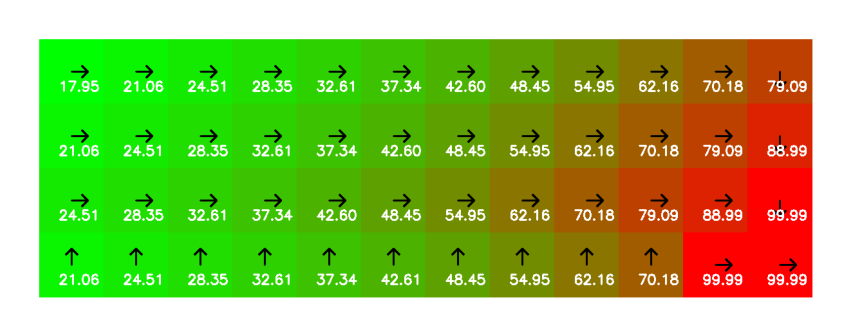

In [0]:
display_policy(policy, V)

# Part 2: Setting up Deep Q-Learning with Cart Pole (35 pts)

Recall that in reinforcement learning, an actor's job is to make **actions** $A$ in accordance with observed **states** $S$ in a particular environment. In return, the actor receives a reward $r \in R$. The actor is then expected to refine their strategy in order to make better actions in future.

In this section, we'll be looking at the Cart Pole problem: a cart is holding a pole up, and the actor's job is to apply force (left or right) to the cart to keep the pole up.

Run the following code to import the environment for the Cart Pole problem:



In [0]:
import gym

env = gym.make('CartPole-v0')

`env` is now a variable that contains information about the Cart Pole environment. Let's get a better sense of what its state and action spaces look like.

### 2.1: Understanding the simulator

You can use the `observation_space` and `action_space` attributes to look at properties of the state and action spaces, respectively. Run the following code snippets below:

In [0]:
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)
print(env.action_space)

Box(4,)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
Discrete(2)


**Q2a (5 pts)** What do each of variables mean? What are the individual components of the observation space? In the writeup, explain what each of the four elements of the observation space are and what their bounds are. Explain the environment's action space in the writeup as well.

If you need more help figuring out what these values are, feel free to watch the recitation where we discuss what these parameters represent. Additionally you can look the [Open AI Github Page](https://github.com/openai/gym/wiki/CartPole-v0). 

**Note:** This page is a bit out of date so be careful to not use the exact numbers listed on the github page.

### 2.2: Understanding the Reward Function
Next, we'll explore the reward function for the DQN and derive a loss function for it. First, let's understand how rewards are generated for the Cartpole problem.

First, look again at the [Open AI Github Page](https://github.com/openai/gym/wiki/CartPole-v0).

**Q2b (5 pts)** In your writeup describe the reward function for this problem. How much is the actor rewarded on each timestep of an episode, and under what conditions does it occur? 

### 2.3: Deriving the Loss Function

In Q-learning, an actor can gauge which actions to pick at a certain state by approximating the function $Q : S \times A \to \mathbb{R}$; that is, $Q(s, a)$ for a state $s$ and an action $a$ is a measure of the value of taking action $a$ while at state $s$. 

Recall that we want to ideally update $Q$ according to the following update rule:

$$ Q(s, a) \leftarrow (1 - \alpha)Q(s_t,a_t) + \alpha\left(r_t + \gamma\max_a Q(s_{t+1}, a_{t+1}) \right)$$
where $s_{t+1}$ is the state that results from taking action $a$ in state $s_t$, $r_t$ is the reward obtained, and $\gamma$ is the discount factor.

**Intuition:** The intuition behind this update rule, is that $Q(s,a)$ estimates the total reward that an agent will receive for the remainder of the simulation given the state $s_t$ and action $a_t$ that the agent takes. Therefore, we weight the old approximation by a factor of $1 - \alpha$ and then we estimate the total future reward by taking the extrinsic reward $r$ we received, and adding to it the maximum estimated reward we can receive from state $s'$ by choosing the reward that maximizes $Q(s', a')$.

When does this converge? Note that if both $Q(s_t,a_t)$ and $\left(r_t + \gamma\max_a Q(s_{t+1}, a_{t+1})\right)$ are always equal, then $Q(s,a)$ has converged. Therefore to approximate the Q function, we can instead minimize the following function:

$$ ((r_t + \gamma \max_a Q(s_{t+1}, a)) - Q(s_t, a_t))^2$$

**Q2c (10 pts)** Using only the values below,  code up the loss function for a Q-Learning algorithm in PyTorch specifically with respect to the Cart-Pole problem. Submit a screenshot of your implementation in your writeup as well as an explanation.

**Note:** Don't forget about the action space you expored in part 2.1!

In [0]:
def calculate_loss(gamma, reward, Q_t, Q_next):
  """ Method header to calculate the loss.
  NOTE: THIS CODE SNIPPET WILL NOT WORK RIGHT NOW, BUT SHOULD ONCE YOU HAVE
  EVERYTHING ELSE IMPLEMENTED

  Args:
      gamma  (float) : Discount for rewards
      reward (int)   : Reward for action taken
      Q_t    (tensor): Tensor of Q-Values for the action at time t
      Q_next (tensor): Tensor of Q-Values for the action at time t+1
  """  
  # TODO: Insert your code here
  pass

calculate_loss = nn.MSELoss()

### 2.4: Defining the Neural Network Architecture

In regular Q-Learning we have a table of size $|S| \times |A|$ where each entry in the table represents the estimated reward. However, this space can be extremely large, so we instead approximate this mapping with a neural network instead.

Think carefully about how you should define your neural network architecture. What are your inputs? What are your outputs?

**Q2d (5 pts)** Implement the neural network to approximate the Q function below. In your writeup explain what the inputs and outputs are for your neural network.

In [0]:
import torch
import torch.nn as nn

class DQNetwork(nn.Module):
    """ Template class for your DQN. Please feel free to modify headers as needed.
    """
    def __init__(self): 
      super(DQNetwork, self).__init__()
      self.net = nn.Sequential(
          nn.Linear(4, 128),
          nn.ReLU(),
          nn.Linear(128, 32),
          nn.ReLU(),
          nn.Linear(32, 2) )

    def forward(self, s):
      return self.net(s.float())

policy_net = DQNetwork()
optimizer = torch.optim.Adam(policy_net.parameters())

### 2.5: Replay Buffer

Before we actually write our training loop, let's carefully think about how the training loop should be structured first. One's first thought is that the best course of action is to run the training linearly with time. By this we mean you start your simulation at time t=0, perform the loss minimization above, progress to time t=1, repeat until the simulation has finished. 

**This is a bad idea.** 

Why? In the Cart-Pole problem, the simulation stops (and is successful) if the cart can balance the pole for 200 subsequent steps. Remember that neural networks have one key fault, which is that they exhibit **catastrophic forgetting**. Therefore, by the time the neural network gets to the last 200 steps, it may have forgotten completely what it learned in the first 100 steps! 


To solve this issue, it is common practice in Deep Q-Learning to implement **Memory Replay**. When implementing this, we sample a batch representing previous situations encountered, and train on this instead. Since these situations are randomly sampled and have no dependence on time, we break this time dependence and threfore circumvent the issue of catastrophic forgetting.

**Q2e (5 pts)** Implement a ReplayBuffer below as a FIFO queue of maximum capacity that you initialize the buffer with. You should be able to push a new memory to the replay buffer, and also randomly sample a batch from the ReplayBuffer. In the writeup, describe your tuple "replay" in the push function. What are the elements of your tuple? Why? 

*Hint:* think about the loss function you derived earlier.

In [0]:
import collections
import random

class ReplayBuffer:
  """ ReplayBuffer is a Buffer that allows us to implement Memory Replay.
      Feel free to modify the method signatures as you like, this is simply
      how we implemented it.
  """
  def __init__(self, capacity):
    """ Initializes the ReplayBuffer
    Args:
      capacity (int): The maximum number of memories stored in the ReplayBuffer
    """
    self.capacity = capacity
    self.memory = collections.deque()

  def push(self, replay):
    """ Pushes a new memory to ReplayBuffer. If at capacity, removes first
    memory stored (FIFO).

    Args:
      replay (Tuple): The tuple of all pertinent information for the replay
    """
    if len(self.memory) < self.capacity:
      self.memory.append(replay)
    else:
      self.memory.popleft()
      self.memory.append(replay)

  def sample(self, batch_size):
    """ Randomly samples a batch of size 'batch_size' from the ReplayBuffer

    Args:
      batch_size (int): Integer representing the desired batch size to be sampled

    Returns:
      Tuple representing the replay
    
    Hint: You can use random.sample to do this really easily
    """
    return random.sample(self.memory, batch_size)

  def __len__(self):
    """ 
    Returns:
      (int) Returns the current length of the Replay Buffer
    """
    return len(self.memory)

memory = ReplayBuffer(1000)

### 2.6: $\varepsilon$-greedy action selection

*Curiosity killed the cat, right?* Well in reinforcement learning, curiosity, namely *exploration* is crucial in reinforcement learning to learn adequately. A common motif is **exploration vs. exploitation**, which describes the tradeoffs between selecting the best possible action known to us versus exploring the action space more by selecting a random action. You can think of this tradeoff like "should I go to that restaurant that I know is really really good, or should I instead try out that new restaurant that I've never been to". However, since we're all social distancing, I guess this point is moot anyways.

Now, let's implement the **$\varepsilon$ greedy algorithm**, which does exactly what was mentioned above:

**Q2f (5 pts)** Implement a function that accepts a set of Q-values corresponding to a set of actions $A$, and a parameter $\varepsilon$, that does the following:
- With probability $\varepsilon$, returns the action that yields the maximum Q-value.
- With probability $1 - \varepsilon$, returns a randomly chosen action. 

In your writeup, answer the following question:
If you have simulated $N=10000$ steps, and have a $\varepsilon$ of .99, what is the expected number of random actions that you will take? What about if $\varepsilon$ is .9 instead? How many more random actions will you take with the latter value of $\varepsilon$ than the former. Explain how varying this parameter changes how the agent learns.


In [0]:
def epsilon_greedy_action(q_values, epsilon):
  """
  Implements an epsilon-greedy action selection.
  
  Args:
    q_values (Tensor):  Tensor representing the predicted q_values for each action
    epsilon  (Float):  Float from 0-1 representing the probability of selecting a random action, instead of the optimal
    
  """
  if torch.rand(1) < epsilon:
    return torch.tensor(random.sample(range(len(q_values)), 1))    
  else:
    return torch.tensor([torch.argmax(q_values)])

# Part 3: Running Deep Q-Learning with Cart Pole (50 pts)

Now that we have all of our components implemented, let's put them all together! First implement the function to update the weights for the DQN:

In [0]:
from torch.autograd import Variable
def learn(memory):
  """ Method that updates the DQN parameters for a single batch sampled from the 
      Memory Replay Buffer. Feel free to modify the method header as you like.
  """

  """ Pseudocode:
      1. Sample batch from ReplayBuffer
      2. From the ReplayBuffer feed in state at time t to the DQN
      3. From the ReplayBuffer feed in state at time t + 1 to the DQN
      4. Detach the output from step 3
      5. Calculate Loss
      6. Zero Optimizer Gradient
      7. Backpropagate Loss
      8. Step Optimizer
  """
  if len(memory) < batch_size: return
  replays = memory.sample(batch_size)
  i = 0
  Q_t, expected_reward = torch.zeros(batch_size), []
  for state, action, next_state, reward, done in replays:
       if done:
            expected_reward.append(reward)
       else:
            q_next = policy_net(torch.tensor(next_state)).detach()
            expected_reward.append(reward + gamma * torch.max(q_next).item())
       Q_t[i] = policy_net(torch.tensor(state))[action]
       i += 1
  
  Q_next = Variable(torch.tensor(expected_reward))
  loss = calculate_loss(Q_t, Q_next)
  optimizer.zero_grad()
  loss.backward()
  for param in policy_net.parameters():
      param.grad.data.clamp_(-1, 1)
  optimizer.step()  
  
  return loss.item()

Now, let's implement the loop that simulates the CartPole problem for a single episode.

In [0]:
def run_episode(env, epsilon, episode):
  """ Method that runs a single episode of the CartPole problem. Feel free to
      modify the method header as you like. 
  """
  state = env.reset()
  rewards, losses, iterations = 0, 0, 0
  while True:
    """ Pseudocode:
        1. Input state into your network to get the predicted Q Values for each action
        2. Use "epsilon_greedy_action" to get your next action from your Q-Values
        3. Once you've done the first two steps, you can simulate tacking the action "action" in the environment as follows. 
          Here we assume "action" is an integer that is either 0 or 1 (left or right).

      Return Values: 
        next_state: (Tuple) Next state after having taken action "action"
        reward  : (int)   Reward received for taking action "action"
        done   : (bool)  Whether or not the simulation has reached an ending condition (see github repo linked earlier for more information)
    """ 
    env.render(mode='rgb_array')
    q_values = policy_net(torch.tensor(state).float()).detach()
    action = epsilon_greedy_action(q_values, epsilon)
    next_state, reward, done, _ = env.step(np.array(action.item())) 
    rewards += reward
    iterations += 1
    reward = reward if not done else -reward 
    """ Pseudocode (cont):
        4. (Optional) Call cool_video.add_frame to add a frame to your video
        5. Push this information to your ReplayBuffer
        6. Set your current state to the next state returned
        7. Call "learn" for a single batch
        8. (Optional) Call cool_video.done to signal that it finished the episode
        9. Check if the simulation is done, and if so exit out of the function.
          If the simulation is not done, then we loop and repeat steps 1-9
    """
    cool_video.add_frame(env, episode)
    memory.push(tuple([state, action, next_state, reward, done]))
    state = next_state
    loss = learn(memory)
    losses += loss if loss else 0
    cool_video.done(rewards)
    if done: break

  return rewards, losses/iterations, iterations

Finally, let's run the loop for the desired # of episodes!

In [0]:
# TODO: Run "run_episode" for the number of desired episodes.
# If you want to generate the video, call cool_video.generate_video_at_path to generate your training video at your desired path. 
# We recommend saving to Google Drive so you can watch it immediately.
import numpy as np
batch_size = 32
episodes = 100 
gamma = 0.9
all_rewards, all_losses = [], []
for episode in range(episodes):
  epsilon = 0.3/np.sqrt(episode+1)
  rewards, losses, iterations = run_episode(env, epsilon, episode)
  all_rewards.append(rewards)
  all_losses.append(losses)
  if episode % 10 == 0:
    print("episode: {:2d}, iteration: {:2d}, epsilon: {:.4f}, average reward: {:.4f}".format(episode, iterations, epsilon, np.array(all_rewards[max(0, episode-9):(episode+1)]).mean()))
    if np.array(all_rewards[max(0, episode-9):(episode+1)]).mean() >= 200: break

# cool_video.generate_video_at_path('C:/Users/Mian Wang/Desktop/cartpole.avi')

episode:  0, iteration: 17, epsilon: 0.3000, average reward: 17.0000
episode: 10, iteration: 22, epsilon: 0.0905, average reward: 20.8000
episode: 20, iteration: 35, epsilon: 0.0655, average reward: 18.3000
episode: 30, iteration: 200, epsilon: 0.0539, average reward: 81.0000
episode: 40, iteration: 159, epsilon: 0.0469, average reward: 195.9000
episode: 50, iteration: 200, epsilon: 0.0420, average reward: 189.8000
episode: 60, iteration: 200, epsilon: 0.0384, average reward: 197.0000
episode: 70, iteration: 200, epsilon: 0.0356, average reward: 181.0000
episode: 80, iteration: 120, epsilon: 0.0333, average reward: 179.4000
episode: 90, iteration: 200, epsilon: 0.0314, average reward: 186.1000
episode: 100, iteration: 200, epsilon: 0.0299, average reward: 174.2000
episode: 110, iteration: 200, epsilon: 0.0285, average reward: 200.0000


**Q3a (30 pts)** After implementing the above, tune your hyperparameters until you have a CartPole implementation that averages a reward of > 175 over 10 episodes. Having that performance will give you full credit for this problem. 

In your writeup report your loss graph (you can either choose to plot the loss per step of each episode, or the average loss over an entire episode -- the former will be more noisy). Also in your writeup report a plot that shows the total reward obtained per episode. Also report your average reward over your final 10 episodes of training.

Breakdown of points:

1.   Loss graph (5 pts)
2.   Reward graph (5 pts)
3.   Performance (20 pts):

     a. >= 175 average over 10 episodes (20/20 pts) 

     b. >= 150 average over 10 episodes (15/20 pts)

     c. >= 100 average over 10 episodes (10/20 pts)

     d. >= 50 average over 10 episodes (5/20 pts)





**Extra Credit (3 pts):** As extra credit, also plot on top of this a curve that displays the running average reward for the past 10 episodes (effectively smoothing out this curve). 

**Note:** We know everyone is tired of tensorboard at this point so feel free to use matplotlib or whatever plotting software you like best.

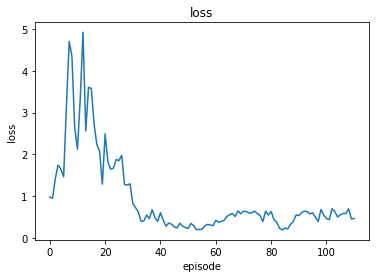

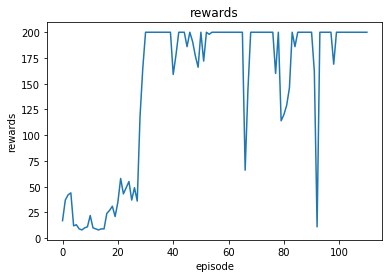

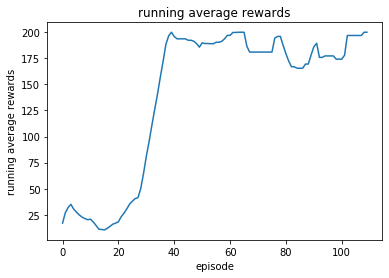

In [0]:
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.title('loss')
plt.xlabel('episode')
plt.ylabel('loss')
plt.show()
plt.plot(all_rewards)
plt.title('rewards')
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()
running_average_reward = [np.array(all_rewards[max(0, episode-9):(episode+1)]).mean() for episode in range(episodes)]
plt.plot(running_average_reward)
plt.title('running average rewards')
plt.xlabel('episode')
plt.ylabel('running average rewards')
plt.show()

In [0]:
print(max(running_average_reward))
print(running_average_reward[-1])

200.0
200.0


**Q3b (10 pts)** In the writeup explain how your process for tuning hyperparameters as well as what your final hyperparamters are.

**Q3c (10 pts)** Remember how in step 4 of the learn function you detached the output from the previous step? Try not detaching it instead. Report the new loss / reward curves in the writeup. Also in your writeup, intuitively explain why this occurs / why it is therefore necessary to detach the output.

In [0]:
from torch.autograd import Variable
def learn_without_detach(memory):
  if len(memory) < batch_size: return
  replays = memory.sample(batch_size)
  i = 0
  Q_t, expected_reward = torch.zeros(batch_size), []
  for state, action, next_state, reward, done in replays:
       if done:
            expected_reward.append(reward)
       else:
            q_next = policy_net(torch.tensor(next_state))
            expected_reward.append(reward + gamma * torch.max(q_next).item())
       Q_t[i] = policy_net(torch.tensor(state))[action]
       i += 1
  
  Q_next = Variable(torch.tensor(expected_reward))
  loss = calculate_loss(Q_t, Q_next)
  optimizer.zero_grad()
  loss.backward()
  for param in policy_net.parameters():
      param.grad.data.clamp_(-1, 1)
  optimizer.step()  
  
  return loss.item()

In [0]:
def run_episode_without_detach(env, epsilon, episode):
  """ Method that runs a single episode of the CartPole problem. Feel free to
      modify the method header as you like. 
  """
  state = env.reset()
  rewards, losses, iterations = 0, 0, 0
  while True:
        env.render(mode='rgb_array')
        q_values = policy_net(torch.tensor(state).float()).detach()
        action = epsilon_greedy_action(q_values, epsilon)
        next_state, reward, done, _ = env.step(np.array(action.item())) 
        rewards += reward
        iterations += 1
        reward = reward if not done else -reward 

        cool_video.add_frame(env, episode)
        memory.push(tuple([state, action, next_state, reward, done]))
        state = next_state
        loss = learn_without_detach(memory)
        losses += loss if loss else 0
        cool_video.done(rewards)
        if done: break

  return rewards, losses/iterations, iterations

In [0]:
import numpy as np
batch_size = 32
episodes = 100 
gamma = 0.9
all_rewards_without_detach, all_losses_without_detach = [], []
for episode in range(episodes):
      epsilon = 0.3/np.sqrt(episode+1)
      rewards, losses, iterations = run_episode_without_detach(env, epsilon, episode)
      all_rewards_without_detach.append(rewards)
      all_losses_without_detach.append(losses)
      if episode % 10 == 0:
            print("episode: {:2d}, iteration: {:2d}, epsilon: {:.4f}, average reward: {:.4f}".format(episode, iterations, epsilon, np.array(all_rewards_without_detach[max(0, episode-9):(episode+1)]).mean()))
            if np.array(all_rewards_without_detach[max(0, episode-9):(episode+1)]).mean() >= 200: break


episode:  0, iteration: 21, epsilon: 0.3000, average reward: 21.0000
episode: 10, iteration:  9, epsilon: 0.0905, average reward: 10.6000
episode: 20, iteration: 10, epsilon: 0.0655, average reward: 12.3000
episode: 30, iteration: 34, epsilon: 0.0539, average reward: 16.2000
episode: 40, iteration: 70, epsilon: 0.0469, average reward: 56.3000
episode: 50, iteration: 200, epsilon: 0.0420, average reward: 190.0000
episode: 60, iteration: 175, epsilon: 0.0384, average reward: 197.5000
episode: 70, iteration: 200, epsilon: 0.0356, average reward: 187.9000
episode: 80, iteration: 192, epsilon: 0.0333, average reward: 193.4000
episode: 90, iteration: 200, epsilon: 0.0314, average reward: 195.6000


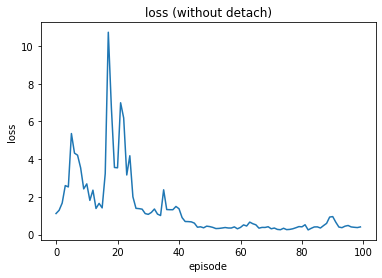

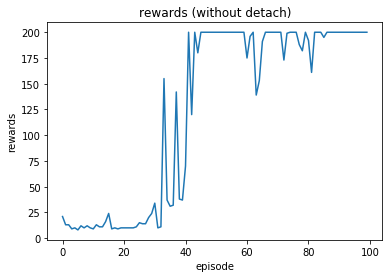

In [0]:
plt.plot(all_losses_without_detach)
plt.title('loss (without detach)')
plt.xlabel('episode')
plt.ylabel('loss')
plt.show()
plt.plot(all_rewards_without_detach)
plt.title('rewards (without detach)')
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

## Generate a Really Cool Video 

This is completely optional, but in this section we provide some code so you can generate a really cool video that shows your CartPole learning over time! Show the video so you can brag to your friends and convince them to take CIS 522 next year! 

In [0]:
import matplotlib.pyplot as plt
import cv2

class CoolVideo:
  """ Use this class to generate a cool video that shows your training progress over time!
      Use it to debug, brag, whatever you feel like. Each time you get a higher total reward
      it keeps the associated frames in the output video.
  """
  def __init__(self):
    self.curr_episode_buffer = []
    self.full_video_buffer = []
    self.max_reward = 0

  def add_frame(self, env, episode):
    frame = env.render(mode='rgb_array')
    font = cv2.FONT_HERSHEY_SIMPLEX
    frame = cv2.putText(np.float32(frame), f'Episode: {episode}',(50,350), font, .5,(0,0,0),1)
    frame = cv2.putText(np.float32(frame), f'Reward: {len(self.curr_episode_buffer) + 1}',(150,350), font, .5,(0,0,0),1)
    self.curr_episode_buffer.append(np.float32(frame))
    # TODO: Add the text for episode + step
    pass
  def done(self, total_reward):
    if total_reward > self.max_reward:
      self.max_reward = total_reward
      self.full_video_buffer.extend(self.curr_episode_buffer)
    self.curr_episode_buffer = []

  def generate_video_at_path(self, path):
    # NOTE: Filename at end of path must end in .avi
    all_frames = self.full_video_buffer

    framerate = 30
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    frame_shape = (400, 600)
    video_writer = cv2.VideoWriter(path, fourcc, framerate, (frame_shape[1], frame_shape[0]), True)

    for frame in all_frames:
      video_writer.write(frame)

    video_writer.release()

cool_video = CoolVideo()

On a side note -- on behalf of all the staff we just want to thank all of you so much for being incredible students! We're being serious in saying that we've learned from all of you as much as you've learned from us. Be sure to keep in touch with the TAs and Dr. Kording -- we'd love to hear what you're up to in the future! Also if you end up making billions of dollars with your super cool unicorn Deep Learning startup, don't forget to remember where it all started ;) JK but it really has been a pleasure teaching all of you!

# Submission Instructions

The deadline for all parts of this assignment is **April 25, 2020 at 11:59pm**.

There are two submissions on Gradescope:
*   HW5 - Reinforcement Learning (Writeup)
*   HW5 - Reinforcement learning (Programming)

For *HW5 - Reinforcement Learning (Writeup)* submit your written responses to the questions above as the file **"522_HW5_writeup.pdf"**

For *HW5 - Reinforcement Learning (Programming)* submit this notebook with the title **"522_HW5_notebook.ipynb"**

**Autograder:** As mentioned earlier, there's no autograder for this homework -- all of it will be graded manually! 